<a href="https://colab.research.google.com/github/poojagulati10/Pooja-Gulati_Assignments/blob/main/Individual_Lab_5_Pooja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 # innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [3]:
#Import Library
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from google.colab import files
uploaded = files.upload()

Saving BostonHousing.csv to BostonHousing.csv


In [11]:
dataset = spark.read.csv('BostonHousing.csv', inferSchema=True, header = True)

In [13]:
#Vectorization
only_feature = ['crim','zn','indus','chas','nox', 'rm', 'age',  'dis','rad','tax','ptratio','b','lstat']

In [14]:
assembler = VectorAssembler(inputCols=only_feature, outputCol = 'feature')

In [15]:
feat_df = assembler.transform(dataset).select('feature')

In [16]:
feat_df.show(5)

+--------------------+
|             feature|
+--------------------+
|[0.00632,18.0,2.3...|
|[0.02731,0.0,7.07...|
|[0.02729,0.0,7.07...|
|[0.03237,0.0,2.18...|
|[0.06905,0.0,2.18...|
+--------------------+
only showing top 5 rows



In [17]:
#Standardize features for principal component analysis
scaler = StandardScaler(
    inputCol = 'feature',
    outputCol = 'scaledFeature',
    withMean = True,
    withStd = True
).fit(feat_df)

In [18]:
df_scaled = scaler.transform(feat_df)
df_scaled.show(6)

+--------------------+--------------------+
|             feature|       scaledFeature|
+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|
|[0.02985,0.0,2.18...|[-0.4166313741807...|
+--------------------+--------------------+
only showing top 6 rows



In [19]:
#Train model for two principal component analysis

n_components = 2
pca = PCA(
    k = n_components,
    inputCol = 'scaledFeature',
    outputCol = 'pcafeature').fit(df_scaled)

df_pca = pca.transform(df_scaled)
print("Explained Variance ratio", pca.explainedVariance.toArray())
df_pca.show(6)

Explained Variance ratio [0.47129606 0.11025193]
+--------------------+--------------------+--------------------+
|             feature|       scaledFeature|          pcafeature|
+--------------------+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|[2.09622303023858...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|[1.45581098944742...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|[2.07254655194818...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|[2.60892175886434...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|[2.45575477193107...|
|[0.02985,0.0,2.18...|[-0.4166313741807...|[2.21266184319277...|
+--------------------+--------------------+--------------------+
only showing top 6 rows



In [20]:
#Collect distributed data in numpy array and then convert to pandas dataframe
X_pca = df_pca.rdd.map(lambda row: row.pcafeature).collect()
X_pca = np.array(X_pca)

In [21]:
X_pca

array([[2.09622303, 0.77234843],
       [1.45581099, 0.59139995],
       [2.07254655, 0.59904658],
       ...,
       [0.31205166, 1.15410433],
       [0.27025162, 1.04033206],
       [0.12567884, 0.76122473]])

In [22]:
#Convery Array to DF
df_pca = pd.DataFrame(X_pca, columns=['PC1','PC2'])
df_pca.head()

,PC1,PC2
0,2.096223,0.772348
1,1.455811,0.591400
2,2.072547,0.599047
3,2.608922,-0.006864
4,2.455755,0.097615


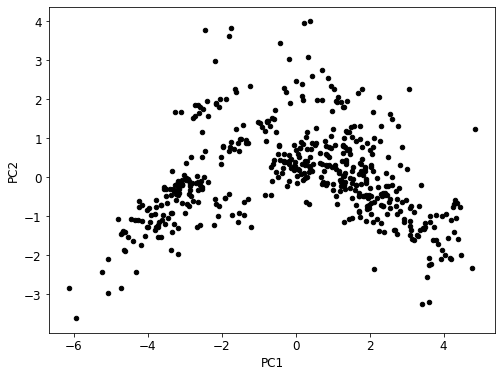

In [23]:
#Plot two principal components
plt.rcParams['figure.figsize'] = 8,6
plt.rcParams['font.size'] = 12
ax1 = df_pca.plot.scatter(x='PC1', y='PC2', c='Black')

In [24]:
#Vectorize features and target together for model development
#Linear Regression


output = assembler.transform(dataset)
#input vs output

finalized_data = output.select('feature','medv')
finalized_data.show()

+--------------------+----+
|             feature|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
|[0.02985,0.0,2.18...|28.7|
|[0.08829,12.5,7.8...|22.9|
|[0.14455,12.5,7.8...|27.1|
|[0.21124,12.5,7.8...|16.5|
|[0.17004,12.5,7.8...|18.9|
|[0.22489,12.5,7.8...|15.0|
|[0.11747,12.5,7.8...|18.9|
|[0.09378,12.5,7.8...|21.7|
|[0.62976,0.0,8.14...|20.4|
|[0.63796,0.0,8.14...|18.2|
|[0.62739,0.0,8.14...|19.9|
|[1.05393,0.0,8.14...|23.1|
|[0.7842,0.0,8.14,...|17.5|
|[0.80271,0.0,8.14...|20.2|
|[0.7258,0.0,8.14,...|18.2|
+--------------------+----+
only showing top 20 rows



In [25]:
#Split dataset into training and testing dataset
train_data, test_data = finalized_data.randomSplit([0.8,0.2]) 

In [26]:
#Fitting Model
regressor = LinearRegression(featuresCol='feature', labelCol='medv')

regressor = regressor.fit(train_data)

In [27]:
#Find out model coefficients and intercept
coeff = regressor.coefficients
intr = regressor.intercept

print("The coef of Model is : %a" %coeff)
print("The Intercept of the model is: %f" %intr)

The coef of Model is : DenseVector([-0.129, 0.0519, 0.008, 2.1761, -18.0271, 3.3686, -0.0065, -1.6567, 0.3254, -0.0125, -0.9219, 0.0091, -0.5612])
The Intercept of the model is: 40.732963


In [28]:
#Evaluate model for test dataset
pred = regressor.evaluate(test_data)

#predict the model
pred.predictions.show()

+--------------------+----+------------------+
|             feature|medv|        prediction|
+--------------------+----+------------------+
|[0.01301,35.0,1.5...|32.7|  29.9935737795553|
|[0.01538,90.0,3.7...|44.0| 37.75269229782404|
|[0.01709,90.0,2.0...|30.1|24.951278216314602|
|[0.02055,85.0,0.7...|24.7| 24.96260779113532|
|[0.02731,0.0,7.07...|21.6|24.908165800985202|
|[0.02899,40.0,1.2...|26.6| 21.87804311827948|
|[0.0315,95.0,1.47...|34.9| 30.45031098747221|
|[0.03306,0.0,5.19...|20.6| 22.70786153336265|
|[0.03427,0.0,5.19...|19.5| 20.59775252600036|
|[0.03548,80.0,3.6...|20.9|21.905937195376104|
|[0.03578,20.0,3.3...|45.4|  38.5514089734488|
|[0.03615,80.0,4.9...|27.9| 32.72325702343862|
|[0.03768,80.0,1.5...|34.6| 34.52520983937335|
|[0.04011,80.0,1.5...|33.3| 36.06430635548429|
|[0.04297,52.5,5.3...|24.8|27.063927085570356|
|[0.04379,80.0,3.3...|19.4|26.176204344862374|
|[0.04417,70.0,2.2...|24.8| 30.68842684834526|
|[0.04544,0.0,3.24...|19.8| 21.80902265965446|
|[0.0456,0.0,

In [29]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol = "medv", predictionCol = "prediction", metricName = "rmse")

#Root Mean Square Error
rmse = eval.evaluate(pred.predictions)
print("RMSE : %f" %rmse)

#mean square error

mse = eval.evaluate(pred.predictions,{eval.metricName: "mse"})

print("MSE: %.3f" % mse)



#mean absolute error

mae = eval.evaluate(pred.predictions,{eval.metricName: "mae"})

print("MAE: %.3f" % mae)



#r2 - coefficient

r2 = eval.evaluate(pred.predictions,{eval.metricName: "r2"})

print("r2: %.3f" % r2)

RMSE : 4.120809
MSE: 16.981
MAE: 3.152
r2: 0.756
